In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import xarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from utils.plotting import prediction_error_plot, plot_station_scatter
import torch
import os
from glob import glob
from tqdm import tqdm

from dataset.dataset import pickle_write, pickle_read
from torchmetrics import R2Score


In [ ]:
from dask.distributed import Client
client = Client()

In [ ]:
stations = xarray.open_zarr('/scratch/snx3000/kschuurm/ZARR/IEA_PVPS_europe.zarr')
sarah = xarray.open_zarr('/scratch/snx3000/kschuurm/ZARR/SARAH3_timeseries_chunk.zarr')
r2score = R2Score()


In [ ]:
print(stations.station_name.values)

In [ ]:
proj = ccrs.PlateCarree()

fig, axis = plt.subplots(1, 1, subplot_kw=dict(projection= one of theproj))

gl = axis.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

axis.coastlines()

lat = stations.latitude.values
lon = stations.longitude.values
name = stations.station_name.values
axis.scatter(x=lon, y=lat, c='r')
for i, txt in enumerate(name):
    axis.annotate(txt, (lon[i], lat[i]))

sarah.channel_data.sel(channel='SIS').isel(time = 10310).plot.imshow(ax=axis, transform = proj)

In [ ]:
 one of thedef sarah_predictions(station, time_window=12):
    print(station, ' Start')
    lat = stations.sel(station_name=station).latitude.values
    lon = stations.sel(station_name=station).longitude.values
    rolling = stations.sel(station_name=station) \
            .rolling(time=time_window,center=False) \
            .mean().dropna(dim='time')
    # rolling average of X minutes (seviri takes X min to create an image, RSS=5min, normal full disk 12min)
    # mean becomes a nan if a single nan value is encountered in GHI

    # mean index is the right most index -> convert to left most index to relate to hrseviri
    rolling['time'] = rolling['time'] - np.timedelta64(time_window, 'm')

    print('sarah samples',len(sarah.time))
    print('station samples', len(rolling.time))
    timenotnan = set(rolling.time.values).intersection(set(sarah.time.values))
    timenotnan = np.sort(np.array(list(timenotnan)))
    print('collocated time-averaged samples:', len(timenotnan))
    
    sarah_timeseries = sarah.sel(time=timenotnan).sel(lat=lat, lon=lon, method='nearest')
    CAB_timeseries = rolling.sel(time=timenotnan)
    y = CAB_timeseries.GHI.values
    y_hat = sarah_timeseries.channel_data.sel(channel='SIS').values
    combined = xarray.merge([sarah_timeseries, CAB_timeseries])
    return y, y_hat, combined, lat, lon

In [ ]:
predictions_stations = {nm: sarah_predictions(nm) for nm in stations.station_name.values}
predictions_stations = {nm: {'y': p[0], 'y_hat':p[1], 'combined': p[2], 'lat':p[3], 'lon':p[4]} for nm, p in predictions_stations.items()} 
pickle_write(predictions_stations, 'baseline_predictions.pkl')

In [ ]:


for key, val in predictions_stations.items():
    y_hat = val['y_hat'].astype(np.float64)
    y = val['y'].astype(np.float64)
    error = torch.tensor(y_hat - y)
    bias = torch.nanmean(error).item()
    mae = torch.nanmean(torch.abs(error)).item()
    std = torch.std(error).item()
    median = torch.nanmedian(error).item()
    rmse = torch.sqrt(torch.nanmean(error**2)).item()
    R2 = r2score(torch.tensor(y_hat, dtype = torch.double), torch.tensor(y, dtype=torch.double)).item()
    val.update({'R2':R2, 'RMSE':rmse, 'MAE':mae, 'Bias':bias})    
    print(f"{key}: \t Bias: {round(bias)}\t RMSE: {round(rmse)} \t MAE: {round(mae)} \t R2score: {round(R2, 3)}")
    fig = prediction_error_plot(y, y_hat, title=key)
    fig.savefig(f'prediction_error_plot_baseline_{key}.png')
    
lats = [val['lat'] for val in predictions_stations.values()]
lons = [val['lon'] for val in predictions_stations.values()]
R2s = [val['R2'] for val in predictions_stations.values()]
rmses = [val['RMSE'] for val in predictions_stations.values()]
maes = [val['MAE'] for val in predictions_stations.values()]
biass = [val['Bias'] for val in predictions_stations.values()]



fig = plot_station_scatter(lats, lons, rmses, predictions_stations.keys(), 'RMSE', vmin=50, vmax=125)
fig.savefig(f'BSRN_RMSE_plot_baseline.png')

fig = plot_station_scatter(lats, lons, maes, predictions_stations.keys(), 'MAE', vmin=30, vmax=80)
fig.savefig(f'BSRN_MAE_plot_baseline.png')

fig = plot_station_scatter(lats, lons, biass, predictions_stations.keys(), 'Bias', cmap='bwr', norm=colors.CenteredNorm())
fig.savefig(f'BSRN_bias_plot_baseline.png')




# DWD

In [ ]:
def sarah_predictions2(station_zarr):
    
    station = xarray.open_zarr(station_zarr)
    lat = station.lat_station.values
    lon = station.lon_station.values
    
    station = station.rename_vars({
                    'GHI':'SIS',
                }).dropna('time')
    
    timenotnan = set(station.time.values).intersection(set(sa one of therah.time.values))
    timenotnan = np.sort(np.array(list(timenotnan)))
    
    sarah_timeseries = sarah.sel(time=timenotnan).sel(lat=lat, lon=lon, method='nearest')
    station = station.sel(time=timenotnan)
    y = station.SIS.values
    y_hat = sarah_timeseries.channel_data.sel(channel='SIS').values
    combined = xarray.merge([sarah_timeseries, station.SIS])
    return y, y_hat, combined, lat, lon

In [ ]:
def statistics(predictions, folder = ''):
    for key, val in predictions.items():
        y_hat = val['y_hat'].astype(np.float64)
        y = val['y'].astype(np.float64)
        error = torch.tensor(y_hat - y)
        bias = torch.nanmean(error).item()
        mae = torch.nanmean(torch.abs(error)).item()
        std = torch.std(error).item()
        median = torch.nanmedian(error).item()
        rmse = torch.sqrt(torch.nanmean(error**2)).item()
        R2 = r2score(torch.tensor(y_hat, dtype = torch.double), torch.tensor(y, dtype=torch.double)).item()
        val.update({'R2':R2, 'RMSE':rmse, 'MAE':mae, 'Bias':bias})    
        print(f"{key}: \t Bias: {round(bias)}\t RMSE: {round(rmse)} \t MAE: {round(mae)} \t R2score: {round(R2, 3)}")
        fig = prediction_error_plot(y, y_hat, title=key)
        fig.savefig(folder + f'prediction_error_plot_baseline_{key}.png')

    lats = [val['lat'] for val in predictions.values()]
    lons = [val['lon'] for val in predictions.values()]
    R2s = [val['R2'] for val in predictions.values()]
    rmses = [val['RMSE'] for val in predictions.values()]
    maes = [val['MAE'] for val in predictions.values()]
    biass = [val['Bias'] for val in predictions.values()]



    fig = plot_station_scatter(lats, lons, rmses, predictions.keys(), 'RMSE', vmin=50, vmax=125)
    fig.savefig(folder + f'RMSE_plot_baseline.png')

    fig = plot_station_scatter(lats, lons, maes, predictions.keys(), 'MAE', vmin=30, vmax=80)
    fig.savefig(folder + f'MAE_plot_baseline.png')

    fig = plot_station_scatter(lats, lons, biass, predictions.keys(), 'Bias', cmap='bwr', norm=colors.CenteredNorm())
    fig.savefig(folder + f'bias_plot_baseline.png')

In [ ]:
folder = 'DWD/'
if not os.path.exists(folder):
    os.mkdir(folder)

zarr_fns = glob('../../ZARR/DWD/DWD_SOLAR_*.zarr')
station_names = [int(os.path.basename(fn).split('SOLAR_')[-1].split('.')[0]) for fn in zarr_fns]



In [ ]:
predictions_DWD = {}
for nm, zarr_fn in tqdm(zip(station_names, zarr_fns), total = len(station_names)):
    if not os.path.exists(folder + f'baseline_predictions_{nm}.pkl'):
        pred = sarah_predictions2(zarr_fn)
        pred = {'y': pred[0], 'y_hat':pred[1], 'combined': pred[2], 'lat':pred[3], 'lon':pred[4]}
        pickle_write(pred, folder + f'baseline_predictions_{nm}.pkl')
    else:
        pred = pickle_read(folder + f'baseline_predictions_{nm}.pkl')
    predictions_DWD[nm] = pred


In [ ]:
statistics(predictions_DWD, folder)

# KNMI

In [23]:
folder = 'KNMI/'
if not os.path.exists(folder):
    os.mkdir(folder)

zarr_fns = glob('../../ZARR/KNMI/KNMI_SOLAR_*.zarr')
station_names = [os.path.basename(fn).split('SOLAR_')[-1].split('.')[0] for fn in zarr_fns]



In [24]:
predictions_KNMI = {}
for nm, zarr_fn in tqdm(zip(station_names, zarr_fns), total = len(station_names)):
    if not os.path.exists(folder + f'baseline_predictions_{nm}.pkl'):
        pred = sarah_predictions2(zarr_fn)
        pred = {'y': pred[0], 'y_hat':pred[1], 'combined': pred[2], 'lat':pred[3], 'lon':pred[4]}
        pickle_write(pred, folder + f'baseline_predictions_{nm}.pkl')
    else:
        pred = pickle_read(folder + f'baseline_predictions_{nm}.pkl')
    predictions_KNMI[nm] = pred

100%|██████████| 14/14 [06:46<00:00, 29.03s/it]


240_S_ISMU: 	 Bias: 2	 RMSE: 76 	 MAE: 33 	 R2score: 0.878
273_S_a: 	 Bias: 4	 RMSE: 58 	 MAE: 26 	 R2score: 0.925
269_S_23t: 	 Bias: 2	 RMSE: 61 	 MAE: 27 	 R2score: 0.92
249_S_a: 	 Bias: -1	 RMSE: 61 	 MAE: 27 	 R2score: 0.92
240_S_ISNK: 	 Bias: 2	 RMSE: 69 	 MAE: 30 	 R2score: 0.901
257_S_a: 	 Bias: 1	 RMSE: 61 	 MAE: 27 	 R2score: 0.925
240_S_18Ct: 	 Bias: 2	 RMSE: 57 	 MAE: 26 	 R2score: 0.928
261_S_a: 	 Bias: 5	 RMSE: 60 	 MAE: 27 	 R2score: 0.917
270_S_a: 	 Bias: 0	 RMSE: 60 	 MAE: 27 	 R2score: 0.92
240_S_ISAD: 	 Bias: -1	 RMSE: 75 	 MAE: 32 	 R2score: 0.885
251_S_a: 	 Bias: -2	 RMSE: 53 	 MAE: 24 	 R2score: 0.941
260_S_a: 	 Bias: 3	 RMSE: 60 	 MAE: 27 	 R2score: 0.919
275_S_a: 	 Bias: 3	 RMSE: 62 	 MAE: 28 	 R2score: 0.912
267_S_a: 	 Bias: -3	 RMSE: 58 	 MAE: 25 	 R2score: 0.931


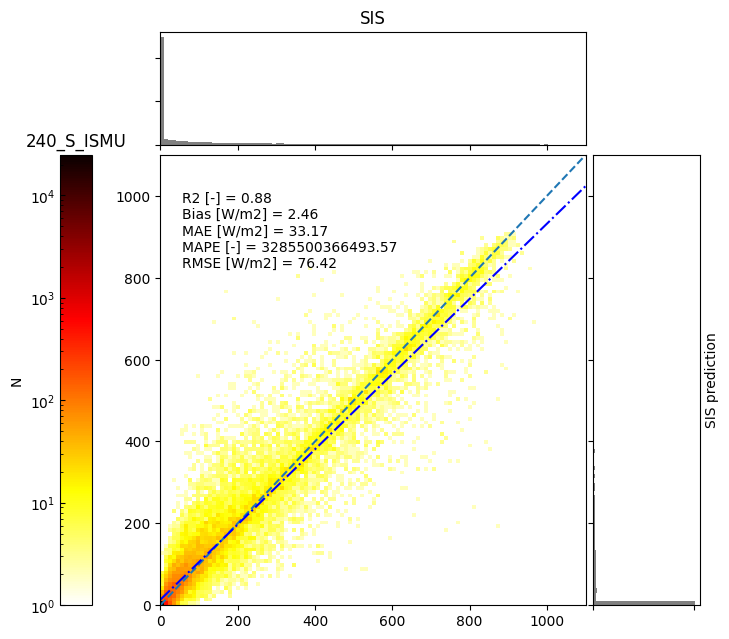

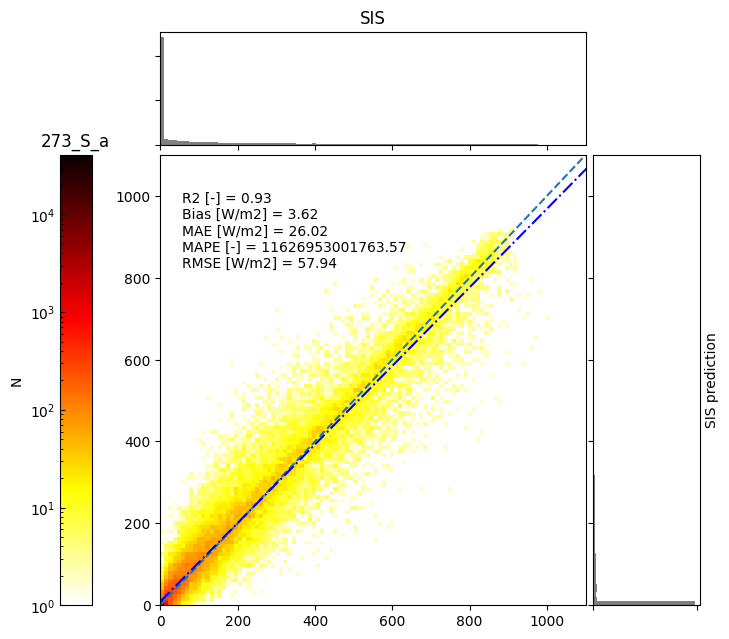

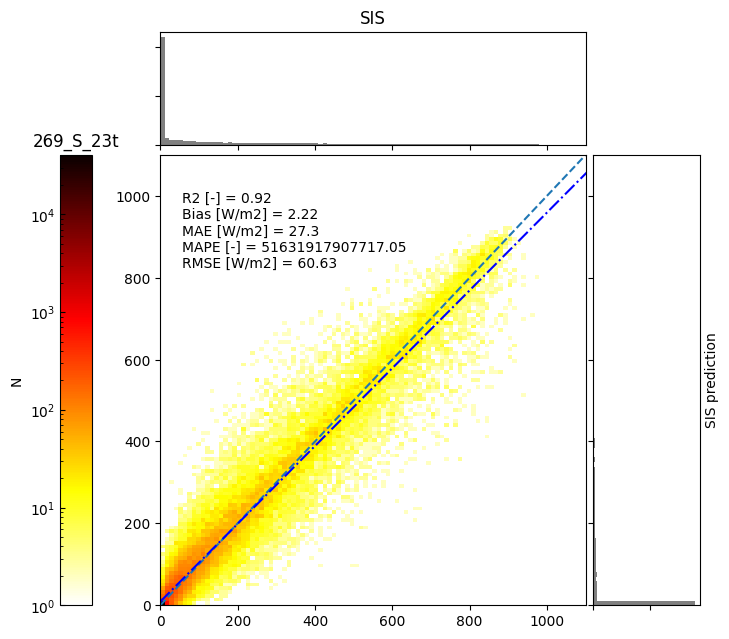

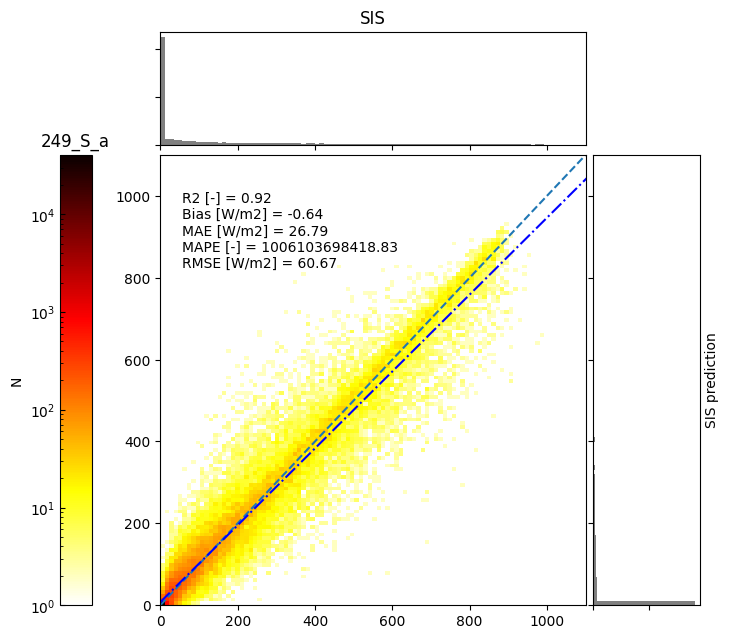

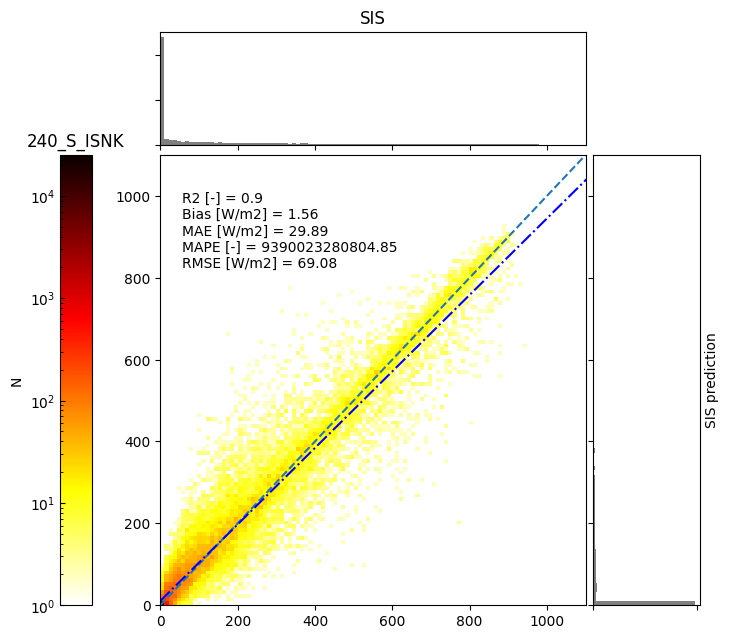

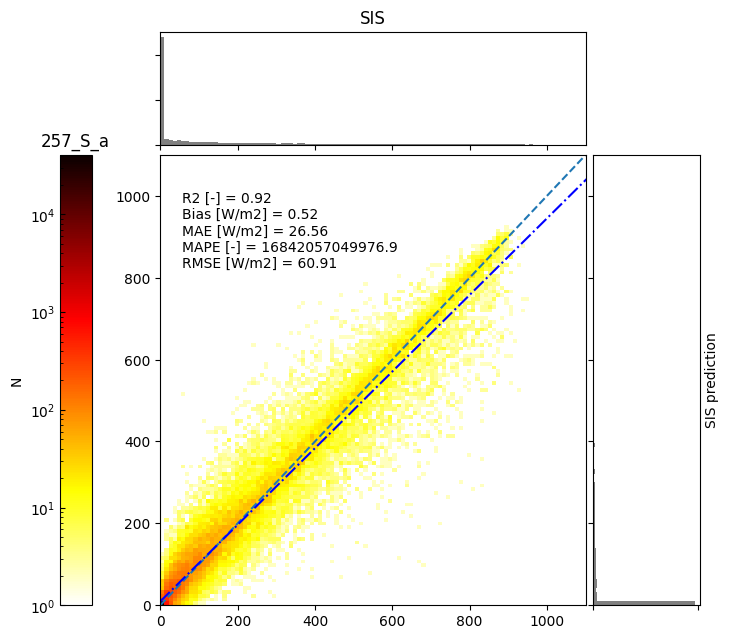

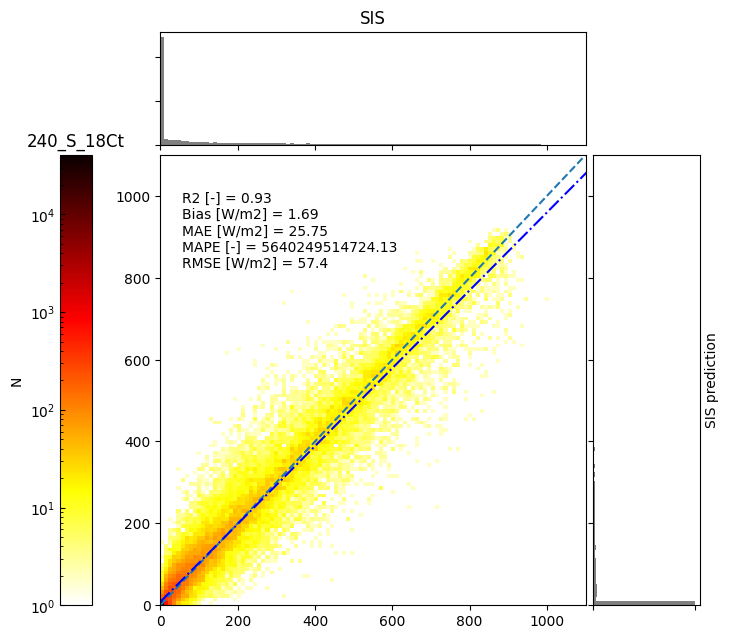

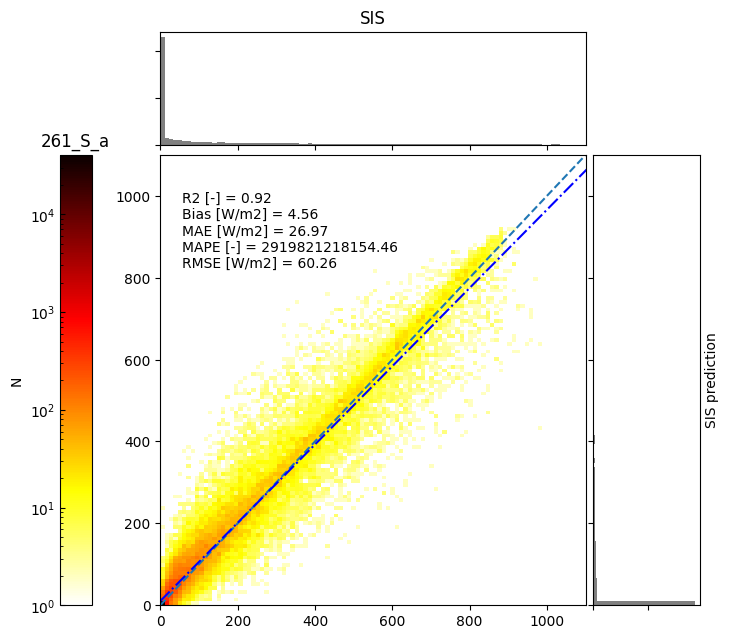

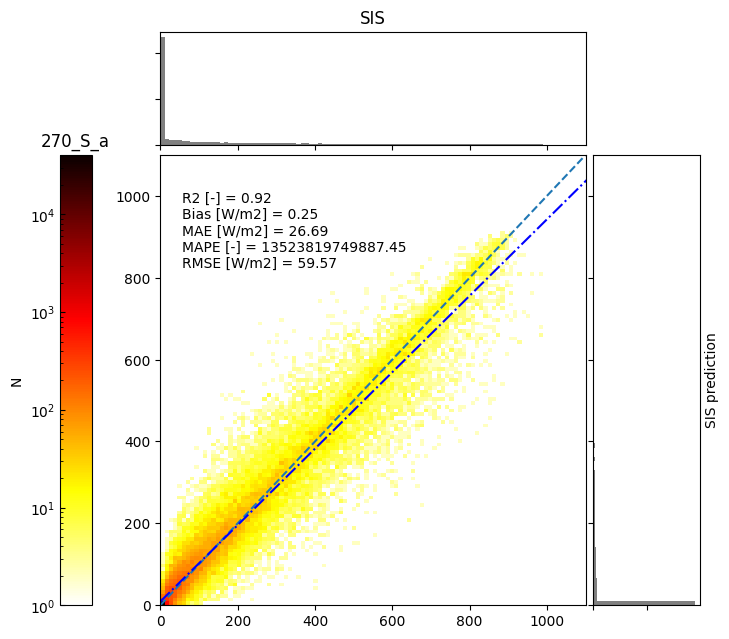

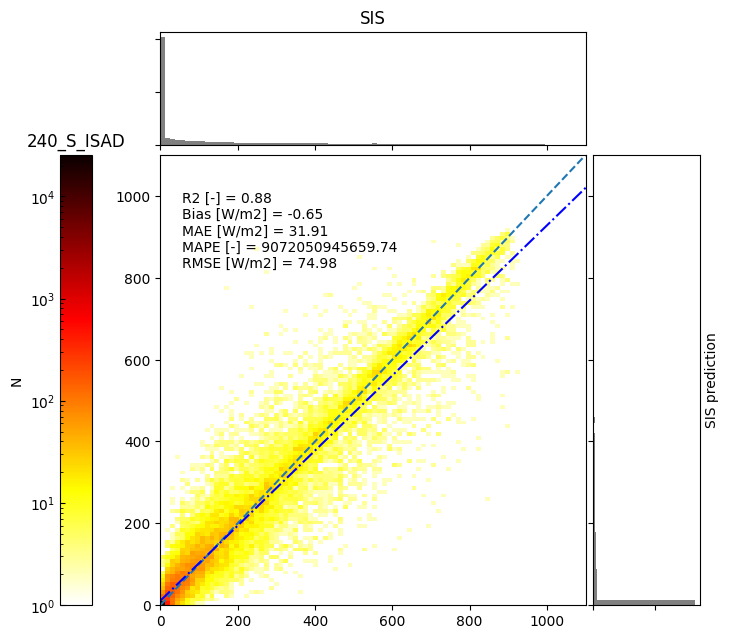

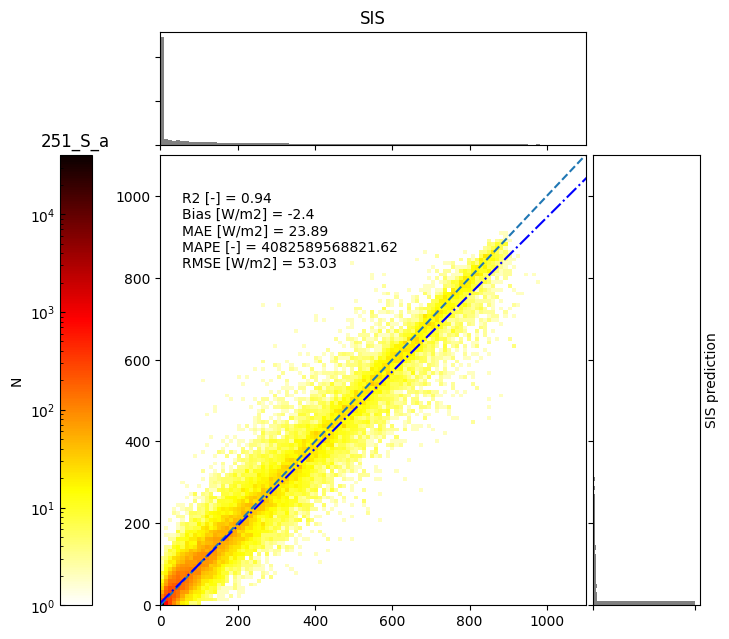

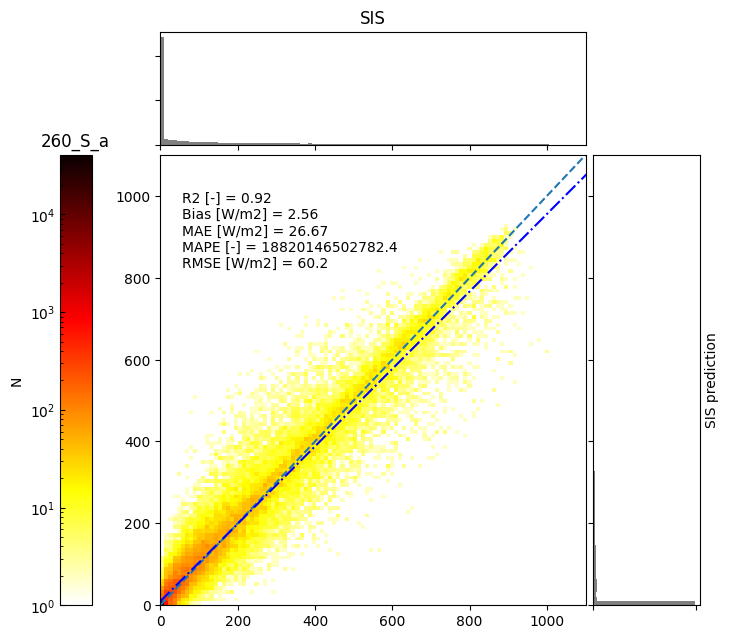

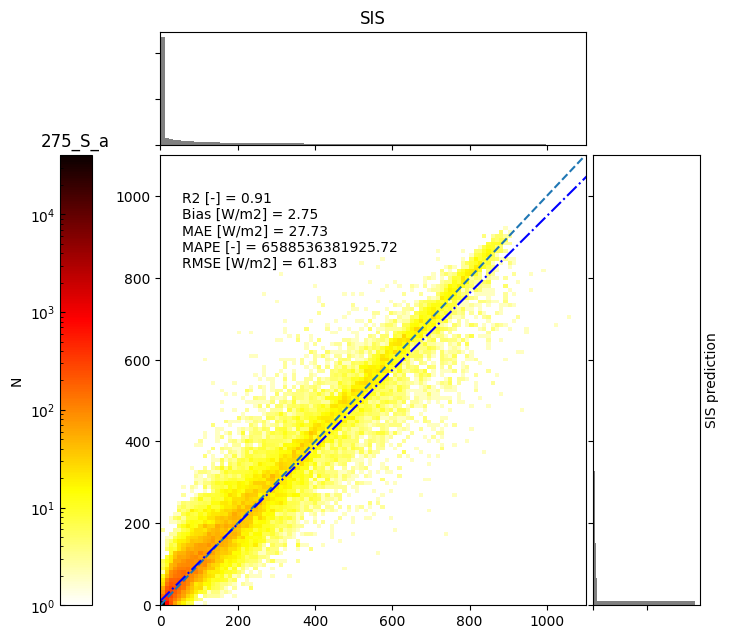

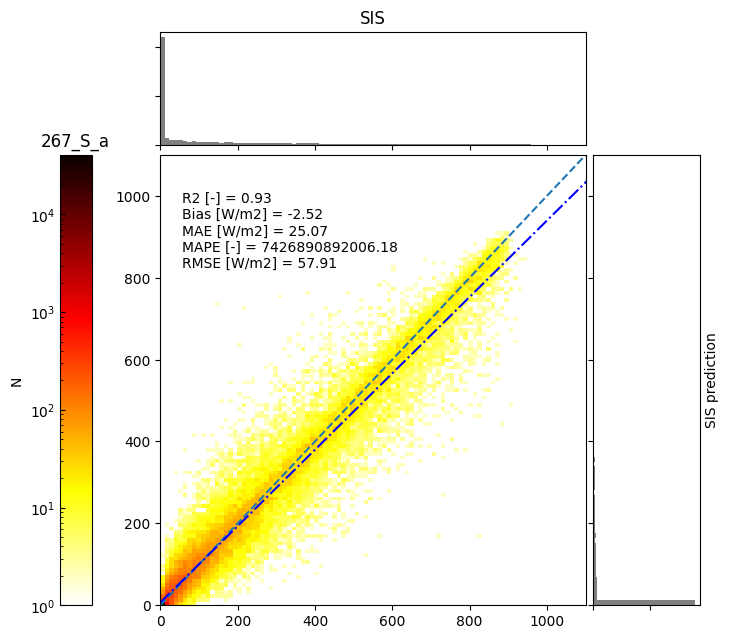

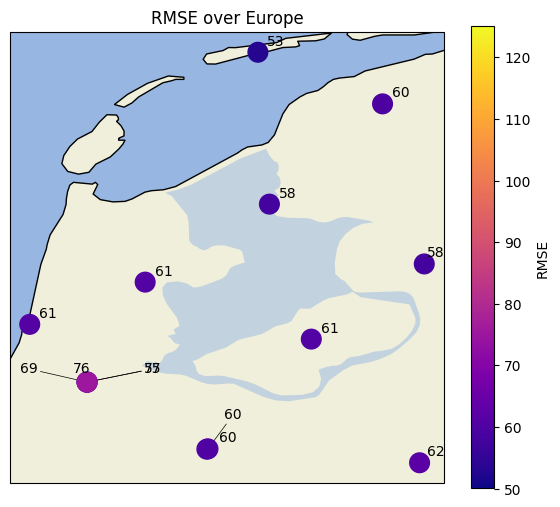

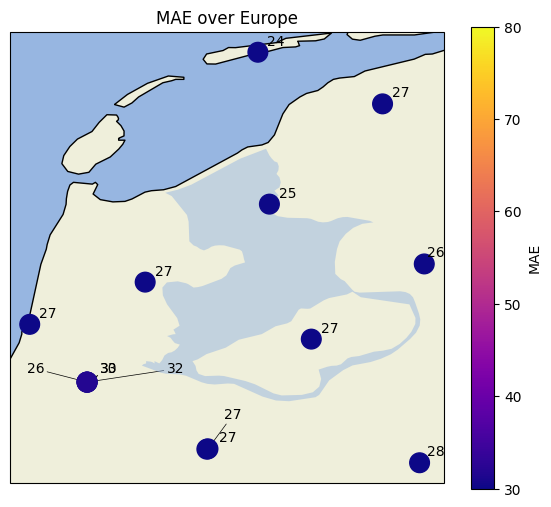

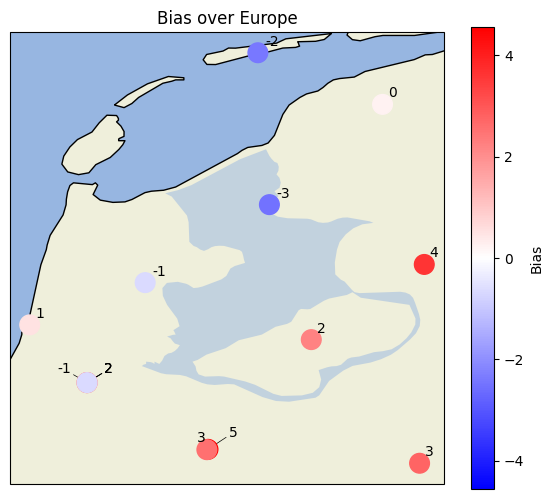

In [25]:
statistics(predictions_KNMI, folder)